# Advanced Spatial Analysis: Spatial Accessibility 2

## Overview

In this lecture, we will advance the 2SFCA method, which was covered in the previous lecture, by integrating **travel time and distance decay functions**. Compared to the original 2SFCA method, this method is called **Enhanced 2SFCA (E2SFCA)** method. The method is defined as follows:

### First step:

$$\huge R_j = \frac{S_j}{\sum_{k\in {\left\{\color{blue}{t_{kj}} \le \color{blue}{t_0} \right\}}}^{}{P_k}\color{blue}{W_k}}$$
where<br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
$S_j$: the degree of supply (e.g., number of doctors) at location $j$. <br>
$P_k$: the degree of demand (e.g., population) at location $k$. <br>
$\color{blue}{t_{kj}}$: the travel <font color='blue'>time</font> between locations $k$ and $j$. <br>
$\color{blue}{t_0}$: the threshold travel <font color='blue'>time</font> of the analysis. <br>
$\color{blue}{W_k}$: Weight based on a distance decay function

### Second step:
$$\huge A_i = \sum_{j\in {\left\{\color{blue}{t_{ij}} \le \color{blue}{t_0} \right\}}} R_j\color{blue}{W_j}$$
where<br>
$A_i$: the accessibility measures at location $i$. <br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
$\color{blue}{W_j}$: Weight based on a distance decay function<br>

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import time
from tqdm import tqdm, trange
from shapely.geometry import Point, MultiPoint
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from shapely.ops import cascaded_union, unary_union
import utils  # Local file
import warnings
warnings.filterwarnings("ignore")

## Let's see the result first

In the maps below, E2SFCA method shows the result measured with threshold travel time **15 minutes**. <br>
The original 2SFCA method shows the result measured with threshold travel **distance 20Km** (=50 mph (80 km/h) * 0.25 hr (15 minutes)).

In [2]:
E_step2 = gpd.read_file('./data/result_E2SFCA.shp')
step2 = gpd.read_file('./data/result_2SFCA.shp')

<AxesSubplot:>

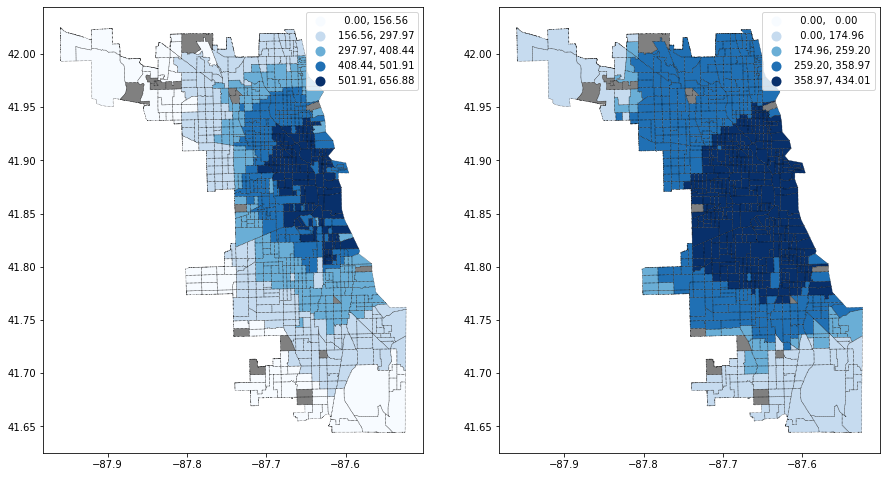

In [3]:
# Plotting accessibility measurement result. 
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# Enhanced 2SFCA method
E_step2.plot('access', ax=ax[0], figsize=(10,10), legend=True, cmap='Blues', scheme='FisherJenks')
E_step2.loc[E_step2['access'] == 0].plot(ax=ax[0], color='grey', zorder=1)
E_step2.boundary.plot(ax=ax[0], linestyle='dotted', lw=0.5, color='black', zorder=1)

# Original 2SFCA method
step2.plot('access', ax=ax[1], figsize=(10,10), legend=True, cmap='Blues', scheme='FisherJenks')
step2.loc[step2['access'] == 0].plot(ax=ax[1], color='grey', zorder=1)
step2.boundary.plot(ax=ax[1], linestyle='dotted', lw=0.5, color='black', zorder=1)

## Import Data - same data as the previous lecture

In [4]:
# Supply: hospitals in the city of Chicago
hospitals = gpd.read_file('./data/Chicago_Hospital_Info.shp')
hospitals.head(1)

,Hospital,City,ZIP_Code,X,Y,Total_Bed,geometry
0,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.9728,145,POINT (-87.67108 41.97280)


In [5]:
# Demand: population per census tract
tracts = gpd.read_file('./data/Chicago_Tract.shp')
tracts.head(1)

,GEOID,OverFifty,TotalPop,geometry
0,17031010400,1103,5153,"POLYGON ((-87.66125 42.01288, -87.66125 42.012..."


<AxesSubplot:>

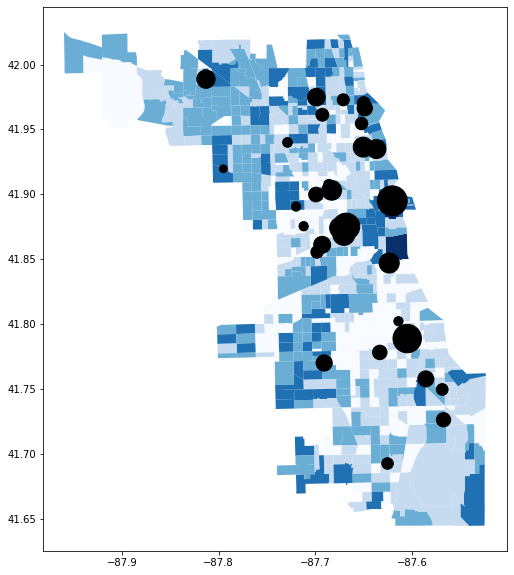

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

tracts.plot('TotalPop', ax=ax, scheme='FisherJenks', cmap='Blues')
hospitals.plot(markersize='Total_Bed', ax=ax, color='black')

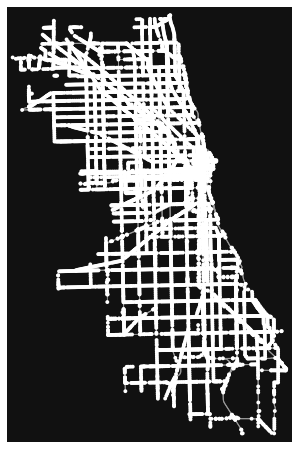

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
# Mobility: Chicago Road Network
G = ox.io.load_graphml('./data/chicago_road.graphml')
ox.plot_graph(G)

In [8]:
# This function helps you to find the nearest OSM node from a given GeoDataFrame
# If geom type is point, it will take it without modification, but 
# IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 

def find_nearest_osm(network, gdf):
    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf

supply = find_nearest_osm(G, hospitals)
demand = find_nearest_osm(G, tracts)

100%|█████████████████████████████████████████| 878/878 [00:37<00:00, 23.32it/s]


## Advancement 1: Caculate the estimated travel time for each edge

To calculate the catchment area based on threshold travel time, we need to calculate how long it would take to travel each network edge. <br>
OSM network has two attributes that are helpful to calculate the estimated travel time for each edge: `length` and `maxspeed`. If we divide `length` into `maxspeed`, we will get the minimum travel time necessary to travel to the edge. 

In [9]:
# Extract the nodes and edges of the network dataset for the future analysis. 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
edges.head()

osmid  oneway  \
u        v          key                                           
702090   261263104  0                          24536463    True   
         1223297118 0             [1000818941, 8220086]    True   
25779161 739968328  0                           4378009    True   
25779173 709393016  0    [24229922, 56716748, 56716749]    True   
         25779174   0                         906195924    True   

                               highway   length  \
u        v          key                           
702090   261263104  0    motorway_link  322.463   
         1223297118 0         motorway  500.211   
25779161 739968328  0         motorway  354.287   
25779173 709393016  0    motorway_link  755.294   
         25779174   0         motorway  123.330   

                                                                  geometry  \
u        v          key                                                      
702090   261263104  0    LINESTRING (-87.81782 41.98343, -87.81838 41.9...   
         1223297118 0    LINESTRING (-87.81782 41.98343, -87.81879 41.9...   
25779161 739968328  0    LINESTRING (-87.66092 41.90090, -87.66068 41.9...   
25779173 709393016  0    LINESTRING (-87.65711 41.89502, -87.65684 41.8...   
         25779174   0    LINESTRING (-87.65711 41.89502, -87.65651 41.8...   

                          lanes        ref                name maxspeed  \
u        v          key                                                   
702090   261263104  0       NaN        NaN                 NaN      NaN   
         1223297118 0    [3, 4]       I 90  Kennedy Expressway   55 mph   
25779161 739968328  0         4  I 90;I 94  Kennedy Expressway   45 mph   
25779173 709393016  0         2        NaN                 NaN      NaN   
         25779174   0         4  I 90;I 94  Kennedy Expressway   45 mph   

                        bridge tunnel width access junction  
u        v          key                                      
702090   261263104  0      NaN    NaN   NaN    NaN      NaN  
         1223297118 0      NaN    NaN   NaN    NaN      NaN  
25779161 739968328  0      NaN    NaN   NaN    NaN      NaN  
25779173 709393016  0      yes    NaN   NaN    NaN      NaN  
         25779174   0      NaN    NaN   NaN    NaN      NaN

You can iterate through the edges in the graph (`G`) with `G.edges()` method. This will return the entry of each edge as the form of dictionary. 

In [10]:
for u, v, data in G.edges(data=True):
    print(type(data), data.keys())

<class 'dict'> dict_keys(['osmid', 'oneway', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'highway', 'length', 'bridge', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'highway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'bridge', 'oneway', 'lanes', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'bridge', 'oneway', 'lanes', 'ref', 'na

<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'bridge', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'width', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'width', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'bridge', 'geometry'])
<class 'dict'> dict_key

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'nam

<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'ref', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'ref', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', '

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'one

<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geom

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'g

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'maxspeed', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid',

<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', '

<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway

<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'maxspeed', 'oneway', 

<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name

<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'le

<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'bridge', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'bridge', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'bridge', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'highway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'r

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'ref', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'ref', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'length', 'geometry']

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'one

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'le

<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'one

<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'tunnel', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highwa

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length', 'bridge', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'highway', 'length', 'bridge', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_

<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'bridge', 'oneway', 'lanes', 'highway', 'length', 'tunnel', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'bridge', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'maxspeed', 'oneway', 'length', 'geometry'])
<class '

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'maxspeed', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'n

<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'maxspeed', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'maxspeed', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'n

<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'lanes', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'ref', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'l

<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'maxspeed', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length'])
<class 'dict'> dict_keys(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'name', 'highway', 'length', 'geometry'])
<class 'dict'> dict_keys(['osmid', 'oneway', 'lanes', 'highway', 'length', 'g

Check the data in the `maxspeed` column. It has the forms of either **string or list**. But, we need to have it as a **numerical form** to do the calculation. 

In [11]:
for u, v, data in G.edges(data=True):
    if 'maxspeed' in data.keys():
        print(data['maxspeed'])

55 mph
45 mph
45 mph
45 mph
45 mph
55 mph
40 mph
40 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
45 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
45 mph
45 mph
45 mph
40 mph
30 mph
30 mph
30 mph
45 mph
45 mph
45 mph
35 mph
50 mph
45 mph
45 mph
45 mph
45 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
55 mph
30 mph
30 mph
30 mph
30 mph
30 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph
30 mph
30 mph
30 mph
30 mph
35 mph
35 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
35 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
40 mph

55 mph
55 mph
55 mph
55 mph
55 mph
30 mph
30 mph
55 mph
55 mph
55 mph
50 mph
55 mph
45 mph
45 mph
45 mph
55 mph
45 mph
45 mph
30 mph
30 mph
30 mph
50 mph
30 mph
30 mph
35 mph
35 mph
30 mph
30 mph
55 mph
45 mph
30 mph
55 mph
55 mph
55 mph
35 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph
45 mph
30 mph
30 mph
30 mph
35 mph
55 mph
['65 mph', '55 mph']
55 mph
40 mph
35 mph
35 mph
40 mph
40 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
55 mph
55 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
55 mph
55 mph
45 mph
55 mph
25 mph
25 mph
35 mph
35 mph
30 mph
55 mph
55 mph
55 mph
55 mph
55 mph
55 mph
45 mph
55 mph
30 mph
30 mph
30 mph
40 mph
35 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
30 mph
55 mph
55 mph
45 mph
55 mph
55 mph
30 mph
30 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph
35 mph

In [12]:
str_test = '55 mph'
str_test.split(' ')

['55', 'mph']

In [13]:
list_test = ['35 mph', '30 mph']
list_test[0].split(' ')

['35', 'mph']

By splitting either list or string, we can obtain the numerical value of max speed, as shown below.

In [14]:
for u, v, data in G.edges(data=True):
    if 'maxspeed' in data.keys():
        if type(data['maxspeed']) == list:
            temp_speed = data['maxspeed'][0]  # extract only the first entry if there are many 
        else: 
            temp_speed = data['maxspeed'] 

        temp_speed = temp_speed.split(' ')[0]  # Extract only the number
        
        data['maxspeed'] = temp_speed # Assign back to the original entry

Examine the replaced values in `maxspeed` column. You will notice that some rows have `NaN` value. 

In [15]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
edges.head()

osmid  oneway  \
u        v          key                                           
702090   261263104  0                          24536463    True   
         1223297118 0             [1000818941, 8220086]    True   
25779161 739968328  0                           4378009    True   
25779173 709393016  0    [24229922, 56716748, 56716749]    True   
         25779174   0                         906195924    True   

                               highway   length  \
u        v          key                           
702090   261263104  0    motorway_link  322.463   
         1223297118 0         motorway  500.211   
25779161 739968328  0         motorway  354.287   
25779173 709393016  0    motorway_link  755.294   
         25779174   0         motorway  123.330   

                                                                  geometry  \
u        v          key                                                      
702090   261263104  0    LINESTRING (-87.81782 41.98343, -87.81838 41.9...   
         1223297118 0    LINESTRING (-87.81782 41.98343, -87.81879 41.9...   
25779161 739968328  0    LINESTRING (-87.66092 41.90090, -87.66068 41.9...   
25779173 709393016  0    LINESTRING (-87.65711 41.89502, -87.65684 41.8...   
         25779174   0    LINESTRING (-87.65711 41.89502, -87.65651 41.8...   

                          lanes        ref                name maxspeed  \
u        v          key                                                   
702090   261263104  0       NaN        NaN                 NaN      NaN   
         1223297118 0    [3, 4]       I 90  Kennedy Expressway       55   
25779161 739968328  0         4  I 90;I 94  Kennedy Expressway       45   
25779173 709393016  0         2        NaN                 NaN      NaN   
         25779174   0         4  I 90;I 94  Kennedy Expressway       45   

                        bridge tunnel width access junction  
u        v          key                                      
702090   261263104  0      NaN    NaN   NaN    NaN      NaN  
         1223297118 0      NaN    NaN   NaN    NaN      NaN  
25779161 739968328  0      NaN    NaN   NaN    NaN      NaN  
25779173 709393016  0      yes    NaN   NaN    NaN      NaN  
         25779174   0      NaN    NaN   NaN    NaN      NaN

If the `maxspeed` column is empty, we can assign maximum travel speed based on their road type. The type is stored in `highway` column. This <a href=https://wiki.openstreetmap.org/wiki/Key:highway> website </a> shows the kinds of attributes and their meanings. 

In [16]:
def assign_max_speed_with_highway_type(row_):
    """
    Assign the maximum speed of an edge based on its attribute 'highway'
    # https://wiki.openstreetmap.org/wiki/Key:highway
    
    Args:
        row_: (dict) a row of OSMnx network data
    
    Returns:
        temp_speed_: (int) the maximum speed of an edge
    
    """
    
    max_speed_per_type = {'motorway': 50, 
              'motorway_link': 30, 
              'trunk': 50,
              'trunk_link': 30, 
              'primary': 40,
              'primary_link': 30, 
              'secondary': 40,
              'secondary_link': 30, 
              'tertiary': 40, 
              'tertiary_link': 20,
              'residential': 30,
              'living_street': 20,
              'unclassified': 20
             }
    
    # if the variable is a list, grab just the first one. 
    if type(row_['highway']) == list: 
        road_type = row_['highway'][0]
    else:
        road_type = row_['highway']
    
    # If the maximum speed of the road_type is predefined.
    if road_type in max_speed_per_type.keys():
        temp_speed_ = max_speed_per_type[road_type]
    else: # If not defined, just use 20 mph. 
        temp_speed_ = 20
    
    return temp_speed_

In [17]:
for u, v, data in G.edges(data=True):
    if 'maxspeed' in data.keys():
        if type(data['maxspeed']) == list:
            temp_speed = data['maxspeed'][0]  # extract only numbers         
        else: 
            temp_speed = data['maxspeed']

        temp_speed = temp_speed.split(' ')[0]
        
    else:
        temp_speed = assign_max_speed_with_highway_type(data)
        
    data['maxspeed'] = temp_speed

Check the `maxspeed` column one more time. You will see all the rows are populated with numerical values.

In [18]:
# Extract the nodes and edges of the network dataset for the future analysis. 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
edges.head()

osmid  oneway  \
u        v          key                                           
702090   261263104  0                          24536463    True   
         1223297118 0             [1000818941, 8220086]    True   
25779161 739968328  0                           4378009    True   
25779173 709393016  0    [24229922, 56716748, 56716749]    True   
         25779174   0                         906195924    True   

                               highway   length  \
u        v          key                           
702090   261263104  0    motorway_link  322.463   
         1223297118 0         motorway  500.211   
25779161 739968328  0         motorway  354.287   
25779173 709393016  0    motorway_link  755.294   
         25779174   0         motorway  123.330   

                                                                  geometry  \
u        v          key                                                      
702090   261263104  0    LINESTRING (-87.81782 41.98343, -87.81838 41.9...   
         1223297118 0    LINESTRING (-87.81782 41.98343, -87.81879 41.9...   
25779161 739968328  0    LINESTRING (-87.66092 41.90090, -87.66068 41.9...   
25779173 709393016  0    LINESTRING (-87.65711 41.89502, -87.65684 41.8...   
         25779174   0    LINESTRING (-87.65711 41.89502, -87.65651 41.8...   

                        maxspeed   lanes        ref                name  \
u        v          key                                                   
702090   261263104  0         30     NaN        NaN                 NaN   
         1223297118 0         55  [3, 4]       I 90  Kennedy Expressway   
25779161 739968328  0         45       4  I 90;I 94  Kennedy Expressway   
25779173 709393016  0         30       2        NaN                 NaN   
         25779174   0         45       4  I 90;I 94  Kennedy Expressway   

                        bridge tunnel width access junction  
u        v          key                                      
702090   261263104  0      NaN    NaN   NaN    NaN      NaN  
         1223297118 0      NaN    NaN   NaN    NaN      NaN  
25779161 739968328  0      NaN    NaN   NaN    NaN      NaN  
25779173 709393016  0      yes    NaN   NaN    NaN      NaN  
         25779174   0      NaN    NaN   NaN    NaN      NaN

Since we have `maxspeed` and `length` data ready for every edge, now we can calculate the estimated travel time per edge. You can simply create/add column like the below. 

In [19]:
for u, v, data in G.edges(data=True):
    data['maxspeed_meters'] = int(data['maxspeed']) * 26.8223 # MPH * 1.6 * 1000 / 60; meter per minute
    data['time'] = float(data['length'] / data['maxspeed_meters'])  # Unit: minutes

In [20]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
edges.head()

osmid  oneway  \
u        v          key                                           
702090   261263104  0                          24536463    True   
         1223297118 0             [1000818941, 8220086]    True   
25779161 739968328  0                           4378009    True   
25779173 709393016  0    [24229922, 56716748, 56716749]    True   
         25779174   0                         906195924    True   

                               highway   length  \
u        v          key                           
702090   261263104  0    motorway_link  322.463   
         1223297118 0         motorway  500.211   
25779161 739968328  0         motorway  354.287   
25779173 709393016  0    motorway_link  755.294   
         25779174   0         motorway  123.330   

                                                                  geometry  \
u        v          key                                                      
702090   261263104  0    LINESTRING (-87.81782 41.98343, -87.81838 41.9...   
         1223297118 0    LINESTRING (-87.81782 41.98343, -87.81879 41.9...   
25779161 739968328  0    LINESTRING (-87.66092 41.90090, -87.66068 41.9...   
25779173 709393016  0    LINESTRING (-87.65711 41.89502, -87.65684 41.8...   
         25779174   0    LINESTRING (-87.65711 41.89502, -87.65651 41.8...   

                        maxspeed  maxspeed_meters      time   lanes  \
u        v          key                                               
702090   261263104  0         30         804.6690  0.400740     NaN   
         1223297118 0         55        1475.2265  0.339074  [3, 4]   
25779161 739968328  0         45        1207.0035  0.293526       4   
25779173 709393016  0         30         804.6690  0.938639       2   
         25779174   0         45        1207.0035  0.102179       4   

                               ref                name bridge tunnel width  \
u        v          key                                                      
702090   261263104  0          NaN                 NaN    NaN    NaN   NaN   
         1223297118 0         I 90  Kennedy Expressway    NaN    NaN   NaN   
25779161 739968328  0    I 90;I 94  Kennedy Expressway    NaN    NaN   NaN   
25779173 709393016  0          NaN                 NaN    yes    NaN   NaN   
         25779174   0    I 90;I 94  Kennedy Expressway    NaN    NaN   NaN   

                        access junction  
u        v          key                  
702090   261263104  0      NaN      NaN  
         1223297118 0      NaN      NaN  
25779161 739968328  0      NaN      NaN  
25779173 709393016  0      NaN      NaN  
         25779174   0      NaN      NaN

In summary, the following codes are what I have explained. 

```python
def network_settings(network):
    for u, v, data in network.edges(data=True):
        if 'maxspeed' in data.keys():
            if type(data['maxspeed']) == list:
                temp_speed = data['maxspeed'][0]  # extract only numbers
            else:
                temp_speed = data['maxspeed']

            temp_speed = temp_speed.split(' ')[0]

        else:
            temp_speed = assign_max_speed_with_highway_type(data)

        data['maxspeed'] = temp_speed
        data['maxspeed_meters'] = int(data['maxspeed']) * 26.8223  # MPH * 1.6 * 1000 / 60; meter per minute
        data['time'] = float(data['length'] / data['maxspeed_meters'])

    # create point geometries for the entire graph
    for node, data in network.nodes(data=True):
        data['geometry'] = Point(data['x'], data['y'])

    return network


def assign_max_speed_with_highway_type(row_):
    max_speed_per_type = {'motorway': 50,
                          'motorway_link': 30,
                          'trunk': 50,
                          'trunk_link': 30,
                          'primary': 40,
                          'primary_link': 30,
                          'secondary': 40,
                          'secondary_link': 30,
                          'tertiary': 40,
                          'tertiary_link': 20,
                          'residential': 30,
                          'living_street': 20,
                          'unclassified': 20
                          }

    # if the variable is a list, obtain just the first one.
    if type(row_['highway']) == list:
        road_type = row_['highway'][0]
    else:
        road_type = row_['highway']

    # If the maximum speed of the road_type is predefined.
    if road_type in max_speed_per_type.keys():
        temp_speed_ = max_speed_per_type[road_type]
    else:  # If not defined, just use 20 mph.
        temp_speed_ = 20

    return temp_speed_

```

In [21]:
def network_settings(network):
    for u, v, data in network.edges(data=True):
        if 'maxspeed' in data.keys():
            if type(data['maxspeed']) == list:
                temp_speed = data['maxspeed'][0]  # extract only numbers
            else:
                temp_speed = data['maxspeed']

            temp_speed = temp_speed.split(' ')[0]

        else:
            temp_speed = assign_max_speed_with_highway_type(data)

        data['maxspeed'] = temp_speed
        data['maxspeed_meters'] = int(data['maxspeed']) * 26.8223  # MPH * 1.6 * 1000 / 60; meter per minute
        data['time'] = float(data['length'] / data['maxspeed_meters'])

    # create point geometries for the entire graph
    for node, data in network.nodes(data=True):
        data['geometry'] = Point(data['x'], data['y'])

    return network


def assign_max_speed_with_highway_type(row_):
    max_speed_per_type = {'motorway': 50,
                          'motorway_link': 30,
                          'trunk': 50,
                          'trunk_link': 30,
                          'primary': 40,
                          'primary_link': 30,
                          'secondary': 40,
                          'secondary_link': 30,
                          'tertiary': 40,
                          'tertiary_link': 20,
                          'residential': 30,
                          'living_street': 20,
                          'unclassified': 20
                          }

    # if the variable is a list, obtain just the first one.
    if type(row_['highway']) == list:
        road_type = row_['highway'][0]
    else:
        road_type = row_['highway']

    # If the maximum speed of the road_type is predefined.
    if road_type in max_speed_per_type.keys():
        temp_speed_ = max_speed_per_type[road_type]
    else:  # If not defined, just use 20 mph.
        temp_speed_ = 20

    return temp_speed_

In [22]:
# Mobility: Chicago Road Network
G = ox.io.load_graphml('./data/chicago_road.graphml')

G = network_settings(G)

# Extract the nodes and edges of the network dataset for the future analysis. 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
edges.head()

osmid  oneway  \
u        v          key                                           
702090   261263104  0                          24536463    True   
         1223297118 0             [1000818941, 8220086]    True   
25779161 739968328  0                           4378009    True   
25779173 709393016  0    [24229922, 56716748, 56716749]    True   
         25779174   0                         906195924    True   

                               highway   length  \
u        v          key                           
702090   261263104  0    motorway_link  322.463   
         1223297118 0         motorway  500.211   
25779161 739968328  0         motorway  354.287   
25779173 709393016  0    motorway_link  755.294   
         25779174   0         motorway  123.330   

                                                                  geometry  \
u        v          key                                                      
702090   261263104  0    LINESTRING (-87.81782 41.98343, -87.81838 41.9...   
         1223297118 0    LINESTRING (-87.81782 41.98343, -87.81879 41.9...   
25779161 739968328  0    LINESTRING (-87.66092 41.90090, -87.66068 41.9...   
25779173 709393016  0    LINESTRING (-87.65711 41.89502, -87.65684 41.8...   
         25779174   0    LINESTRING (-87.65711 41.89502, -87.65651 41.8...   

                        maxspeed  maxspeed_meters      time   lanes  \
u        v          key                                               
702090   261263104  0         30         804.6690  0.400740     NaN   
         1223297118 0         55        1475.2265  0.339074  [3, 4]   
25779161 739968328  0         45        1207.0035  0.293526       4   
25779173 709393016  0         30         804.6690  0.938639       2   
         25779174   0         45        1207.0035  0.102179       4   

                               ref                name bridge tunnel width  \
u        v          key                                                      
702090   261263104  0          NaN                 NaN    NaN    NaN   NaN   
         1223297118 0         I 90  Kennedy Expressway    NaN    NaN   NaN   
25779161 739968328  0    I 90;I 94  Kennedy Expressway    NaN    NaN   NaN   
25779173 709393016  0          NaN                 NaN    yes    NaN   NaN   
         25779174   0    I 90;I 94  Kennedy Expressway    NaN    NaN   NaN   

                        access junction  
u        v          key                  
702090   261263104  0      NaN      NaN  
         1223297118 0      NaN      NaN  
25779161 739968328  0      NaN      NaN  
25779173 709393016  0      NaN      NaN  
         25779174   0      NaN      NaN

---
### *Exercise*

Now we will investigate how the catchment area differs if we utilize threshold travel distance or travel time. <br> Assuming the overall travel speed in the study area is 50 mph, we will compare the catchment areas drawn by 20 km (15 minutes driving distance with 50 mph) and 15 minutes. Change the value of `supply_idx` from 0 to 33, and investigate how the catchment looks different at different supply locations.  

```python
# In summary, the following is the necessary code to create a catchment area from a given location. 
threshold_dist = 20000  # 15 minute driving distance with 50mph. 
threshold_time = 15

supply_idx = 0 # Range can be 0 - 33

# 1. Calculate accessible nodes in the network dataset from a given location 
temp_nodes_time = nx.single_source_dijkstra_path_length(G, supply.loc[supply_idx, 'nearest_osm'], threshold_time, weight='time')
temp_nodes_dist = nx.single_source_dijkstra_path_length(G, supply.loc[supply_idx, 'nearest_osm'], threshold_dist, weight='length')

# 2. Extract the locations (or coordinates) of accessible nodes based on the OSMID.
access_nodes_time = nodes.loc[nodes.index.isin(temp_nodes_time.keys()), 'geometry']
access_nodes_dist = nodes.loc[nodes.index.isin(temp_nodes_dist.keys()), 'geometry']

# 3. Create a convex hull with the locations of the nodes.
access_nodes_time = gpd.GeoSeries(access_nodes_time.unary_union.convex_hull, crs="EPSG:4326")
access_nodes_dist = gpd.GeoSeries(access_nodes_dist.unary_union.convex_hull, crs="EPSG:4326")

# Result. 
demand_time = demand.loc[demand['geometry'].centroid.within(access_nodes_time[0])]
demand_dist = demand.loc[demand['geometry'].centroid.within(access_nodes_dist[0])]

print(f"threshold by time: {demand_time.shape[0]}")
print(f"threshold by distance: {demand_dist.shape[0]}")

# Plot graphs
fig, ax = plt.subplots(figsize=(10, 10))

tracts.plot('TotalPop', ax=ax, scheme='FisherJenks', cmap='Blues')

access_nodes_time.boundary.plot(ax=ax, color='red', linewidth=4)
access_nodes_dist.boundary.plot(ax=ax, color='blue', linewidth=4)

edges.plot(ax=ax, color='black', lw=0.5)

supply_loc = supply.loc[supply.index==supply_idx]
supply_loc.plot(markersize='Total_Bed', ax=ax, color='black')

```

---

threshold by time: 468
threshold by distance: 559


<AxesSubplot:>

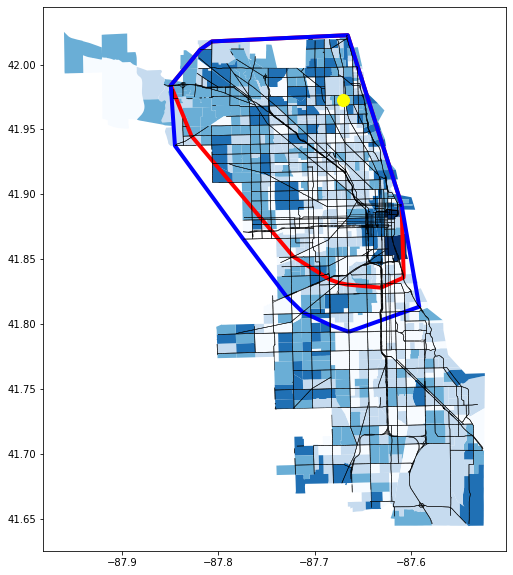

In [23]:
# In summary, the following is the necessary code to create a catchment area from a given location. 
threshold_dist = 20000  # 15 minute driving distance with 50mph. 
threshold_time = 15

supply_idx = 0 # Range can be 0 - 33

# 1. Calculate accessible nodes in the network dataset from a given location 
temp_nodes_time = nx.single_source_dijkstra_path_length(G, supply.loc[supply_idx, 'nearest_osm'], threshold_time, weight='time')
temp_nodes_dist = nx.single_source_dijkstra_path_length(G, supply.loc[supply_idx, 'nearest_osm'], threshold_dist, weight='length')

# 2. Extract the locations (or coordinates) of accessible nodes based on the OSMID.
access_nodes_time = nodes.loc[nodes.index.isin(temp_nodes_time.keys()), 'geometry']
access_nodes_dist = nodes.loc[nodes.index.isin(temp_nodes_dist.keys()), 'geometry']

# 3. Create a convex hull with the locations of the nodes.
access_nodes_time = gpd.GeoSeries(access_nodes_time.unary_union.convex_hull, crs="EPSG:4326")
access_nodes_dist = gpd.GeoSeries(access_nodes_dist.unary_union.convex_hull, crs="EPSG:4326")

# Result. 
demand_time = demand.loc[demand['geometry'].centroid.within(access_nodes_time[0])]
demand_dist = demand.loc[demand['geometry'].centroid.within(access_nodes_dist[0])]

print(f"threshold by time: {demand_time.shape[0]}")
print(f"threshold by distance: {demand_dist.shape[0]}")

# Plot graphs
fig, ax = plt.subplots(figsize=(10, 10))

tracts.plot('TotalPop', ax=ax, scheme='FisherJenks', cmap='Blues')

access_nodes_time.boundary.plot(ax=ax, color='red', linewidth=4)
access_nodes_dist.boundary.plot(ax=ax, color='blue', linewidth=4)

edges.plot(ax=ax, color='black', lw=0.5)

supply_loc = supply.loc[supply.index==supply_idx]
supply_loc.plot(markersize='Total_Bed', ax=ax, color='yellow', zorder=2)

Here, the main difference is created from <a href=https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra_path_length.html>`nx.single_source_dijkstra_path_length()`</a>, which is the function calculating the nodes that are accessible within a certain threshold. 

In [24]:
nx.single_source_dijkstra_path_length(G=G,
                                      source=supply.loc[0, 'nearest_osm'], 
                                      cutoff=20000,
                                      weight='length'
                                     )

{257156478.0: 0,
 2746289365: 175.263,
 286900099: 506.048,
 2447758386: 516.64,
 257157069: 633.781,
 250278855: 669.894,
 257173249: 708.236,
 257157208: 763.8219999999999,
 257168958: 764.2,
 1472093709: 797.241,
 4069241715: 847.3779999999999,
 1299650251: 875.915,
 257172685: 893.5239999999999,
 1370022135: 909.31,
 257110950: 910.502,
 262158757: 939.8549999999999,
 1370022151: 942.194,
 2316599984: 1001.3800000000001,
 2447758391: 1022.79,
 1370022131: 1033.302,
 262158813: 1062.096,
 1370022147: 1063.9029999999998,
 257154258: 1077.1090000000002,
 257110949: 1078.545,
 2869202036: 1113.3129999999999,
 4069241712: 1124.432,
 1370022153: 1166.8389999999997,
 257156476: 1171.2210000000002,
 262158977: 1185.241,
 257154379: 1202.9239999999998,
 4069241716: 1224.772,
 257156271: 1280.2720000000002,
 257168664: 1283.8020000000001,
 257157895: 1308.804,
 26794602: 1316.2019999999998,
 3921165858: 1316.6939999999997,
 2447758377: 1327.7299999999998,
 4069241713: 1328.193,
 291140811: 1

In [25]:
nx.single_source_dijkstra_path_length(G=G,
                                      source=supply.loc[0, 'nearest_osm'], 
                                      cutoff=15,
                                      weight='time'
                                     )

{257156478.0: 0,
 2746289365: 0.16335567792471192,
 286900099: 0.4716672321165598,
 2447758386: 0.48153961442531035,
 257157069: 0.5907220857271749,
 250278855: 0.6243815780153082,
 257173249: 0.6601186326303115,
 257157208: 0.7119281344254595,
 257168958: 0.7122804532049826,
 1472093709: 0.743076656364294,
 4069241715: 0.7898073617847836,
 1299650251: 0.8164055655182443,
 257172685: 0.8328182146944895,
 1370022135: 0.8475317180107598,
 257110950: 0.8486427338445997,
 262158757: 0.8760014987529036,
 1370022151: 0.878181587708735,
 2316599984: 0.9333465064517213,
 2447758391: 0.9533019166887255,
 1370022131: 0.963099734176413,
 262158813: 0.9899374773975388,
 1370022147: 0.9916217102933008,
 257154258: 1.0039304981302872,
 257110949: 1.0052689366683694,
 2869202036: 1.0376748079023799,
 4069241712: 1.0480383859698834,
 1370022153: 1.0875642655551538,
 257156476: 1.0916485536288836,
 262158977: 1.1047160385201868,
 257154379: 1.1211976601559153,
 4069241716: 1.1415613127882398,
 25715627

In [26]:
nx.single_source_dijkstra_path_length(G=G,
                                      source=supply.loc[0, 'nearest_osm'], 
                                      cutoff=15,
#                                       weight='time'
                                     )

{257156478.0: 0,
 2746289365: 1,
 286900099: 2,
 2447758386: 3,
 257173249: 3,
 257157069: 3,
 4069241715: 4,
 250278855: 4,
 257110950: 4,
 257157208: 4,
 2447758391: 5,
 1299650251: 5,
 2316599984: 5,
 257168958: 5,
 2869202036: 5,
 257172685: 5,
 4069241712: 6,
 257110949: 6,
 257154258: 6,
 1472093709: 6,
 26794602: 6,
 262158757: 6,
 4069241716: 7,
 257168664: 7,
 257156476: 7,
 1370022135: 7,
 2447758377: 7,
 26794595: 7,
 2869210430: 7,
 262158813: 7,
 4069241713: 8,
 26794605: 8,
 257156271: 8,
 1370022151: 8,
 2869202035: 8,
 28357781: 8,
 26794594: 8,
 26794585: 8,
 262158977: 8,
 291140811: 9,
 2447758397: 9,
 311438235: 9,
 262163160: 9,
 257168965: 9,
 4069249596: 9,
 1370022131: 9,
 2447758381: 9,
 26794593: 9,
 26794629: 9,
 257157895: 9,
 257159483: 10,
 257156226: 10,
 2447758399: 10,
 3740681129: 10,
 257172366: 10,
 4069249595: 10,
 26808041: 10,
 26794608: 10,
 1370022147: 10,
 2447758384: 10,
 26794631: 10,
 26794549: 10,
 262077540: 10,
 305895971: 10,
 286900086:

## Advancement 2: Apply distance decay functions for catchment areas

Here, we will also start with the result first. 

In [27]:
def calculate_catchment_area(network, nearest_osm, minutes, distance_unit='time'):
    polygons = gpd.GeoDataFrame(crs="EPSG:4326")

    # Create convex hull for each travel time (minutes), respectively.
    for minute in minutes:
        access_nodes = nx.single_source_dijkstra_path_length(network, nearest_osm, minute, weight=distance_unit)
        convex_hull = gpd.GeoSeries(nx.get_node_attributes(network.subgraph(access_nodes), 'geometry')).unary_union.convex_hull
        polygon = gpd.GeoDataFrame({'minutes': [minute], 'geometry': [convex_hull]}, crs="EPSG:4326")
        polygon = polygon.set_index('minutes')
        polygons = polygons.append(polygon)

    # Calculate the differences between convex hulls which created in the previous section.
    polygons_ = polygons.copy(deep=True)
    for idx, minute in enumerate(minutes):
        if idx != 0:
            current_polygon = polygons.loc[[minute]]
            previous_polygons = polygons.loc[[minutes[idx-1]]]
            diff_polygon = gpd.overlay(current_polygon, previous_polygons, how="difference")
            if diff_polygon.shape[0] != 0:
                polygons_.at[minute, 'geometry'] = diff_polygon['geometry'].values[0]

    return polygons_.copy(deep=True)

Demonstration of a catchment area drawn from the supply location 0 for 5, 10 15 minutes threshold travel time. 

<AxesSubplot:>

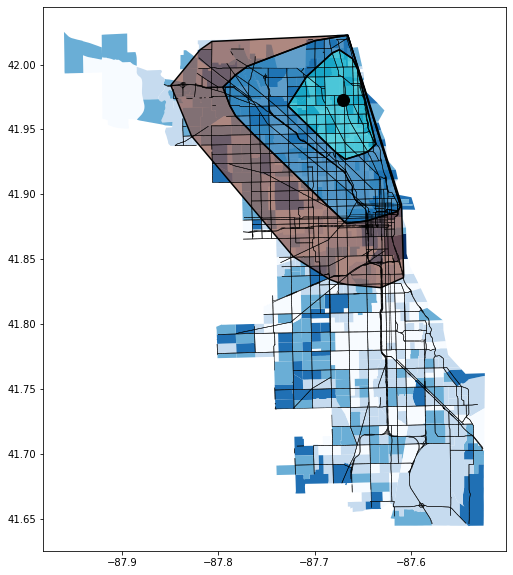

In [28]:
supply_idx = 0 # Range can be 0 - 33

# Calculate catchment areas
areas = calculate_catchment_area(G, supply.loc[supply_idx, 'nearest_osm'], [5, 10,15], distance_unit='time')
areas['val'] = areas.index.astype(str)

# Plot graphs
fig, ax = plt.subplots(figsize=(10, 10))

tracts.plot('TotalPop', ax=ax, scheme='FisherJenks', cmap='Blues')
areas.plot('val', categorical=True, alpha=0.7, ax=ax)
areas.boundary.plot(ax=ax, color='black')
edges.plot(ax=ax, color='black', lw=0.5)

supply_loc = supply.loc[supply.index==supply_idx]
supply_loc.plot(markersize='Total_Bed', ax=ax, color='black')

In [29]:
areas = calculate_catchment_area(G, supply.loc[0, 'nearest_osm'], [5, 10,15], distance_unit='time')
areas

,geometry
minutes,
5,"POLYGON ((-87.66827 41.92696, -87.67815 41.932..."
10,"POLYGON ((-87.66922 41.87885, -87.70687 41.905..."
15,"POLYGON ((-87.66579 42.02264, -87.61005 41.892..."


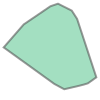

In [30]:
areas.loc[5, 'geometry']

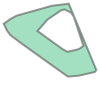

In [31]:
areas.loc[10, 'geometry']

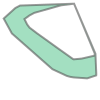

In [32]:
areas.loc[15, 'geometry']

The steps are as follows to create multiple polygons with a hole inside. 
1. Create polygons based on each step of threshold travel time (e.g., 5, 10, 15 minutes)
2. Calculate the difference between a polygon with a bigger threshold travel time and the one with a smaller threshold travel time (e.g., 15 minute polygon - 10 minute polygon). 

In [33]:
minutes = [5, 10, 15]
polygons = gpd.GeoDataFrame(crs="EPSG:4326")

# Create convex hull for each travel time (minutes), respectively.
for minute in minutes:
    # Get the accessible nodes within a certain threshold travel time from the network
    access_nodes = nx.single_source_dijkstra_path_length(G, 
                                                         supply.loc[supply_idx, 'nearest_osm'],
                                                         minute, 
                                                         weight='time'
                                                        )
    # Create the convex hull of accessible nodes
    convex_hull = gpd.GeoSeries(nx.get_node_attributes(G.subgraph(access_nodes), 'geometry')).unary_union.convex_hull
    
    # `convex_hull` is a Shapely Polygon, so need to convert it to GeoDataFrame `polygon`
    polygon = gpd.GeoDataFrame({'minutes': [minute], 'geometry': [convex_hull]}, crs="EPSG:4326")
    
    # Append a GeoDataFrame to another GeoDataFrame
    polygons = polygons.append(polygon)
    
polygons = polygons.set_index('minutes')
polygons

,geometry
minutes,
5,"POLYGON ((-87.66827 41.92696, -87.67815 41.932..."
10,"POLYGON ((-87.66676 41.87763, -87.66922 41.878..."
15,"POLYGON ((-87.63144 41.82803, -87.66673 41.830..."


The result will have multiple polygons but they don't have a hole in it. 

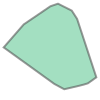

In [34]:
polygons.loc[5, 'geometry']

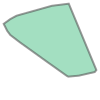

In [35]:
polygons.loc[10, 'geometry']

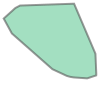

In [36]:
polygons.loc[15, 'geometry']

We can take advantage of <a href=https://geopandas.org/en/stable/docs/reference/api/geopandas.overlay.html>`gpd.overlay()`</a> to calculate the difference between two polygons.

In [37]:
gpd.overlay(polygons.loc[[15]], polygons.loc[[10]], how="difference")
# gpd.overlay(polygons.loc[[15]], polygons.loc[[10]], how="difference").plot()

,geometry
0,"POLYGON ((-87.66579 42.02264, -87.61005 41.892..."


In [38]:
# Key here is that you are subtracting a polygon at the second location from the one at the first location
gpd.overlay(polygons.loc[[10]], polygons.loc[[15]], how="difference")

,geometry


If you make a loop to automate this process, it will be as below. 

In [39]:
# Calculate the differences between convex hulls which created in the previous section.

minutes = [5, 10, 15]

polygons_ = polygons.copy(deep=True)
for idx, minute in enumerate(minutes):
    print(f'The index of {minute} is {idx}')
    
    current_idx = idx
    previous_idx = idx-1
    print(f'In the loop, the current index is {current_idx}, and previous index is {previous_idx}')
    
    current_threshold = minutes[current_idx]
    previous_threshold = minutes[previous_idx]
    print(f'In the loop, the current threshold time is {current_threshold}, and previous threshold time is {previous_threshold}')
    
    print('#-----------#')
#     if idx != 0:
#         current_polygon = polygons.loc[[minute]]
#         previous_polygons = polygons.loc[[minutes[idx-1]]]
#         diff_polygon = gpd.overlay(current_polygon, previous_polygons, how="difference")
#         if diff_polygon.shape[0] != 0:
#             polygons_.at[minute, 'geometry'] = diff_polygon['geometry'].values[0]

The index of 5 is 0
In the loop, the current index is 0, and previous index is -1
In the loop, the current threshold time is 5, and previous threshold time is 15
#-----------#
The index of 10 is 1
In the loop, the current index is 1, and previous index is 0
In the loop, the current threshold time is 10, and previous threshold time is 5
#-----------#
The index of 15 is 2
In the loop, the current index is 2, and previous index is 1
In the loop, the current threshold time is 15, and previous threshold time is 10
#-----------#


Again, the following summarizes steps that create multiple catchment areas from a single origin.

In [40]:
def calculate_catchment_area(network, nearest_osm, minutes, distance_unit='time'):
    polygons = gpd.GeoDataFrame(crs="EPSG:4326")

    # Create convex hull for each travel time (minutes), respectively.
    for minute in minutes:
        access_nodes = nx.single_source_dijkstra_path_length(network, nearest_osm, minute, weight=distance_unit)
        convex_hull = gpd.GeoSeries(nx.get_node_attributes(network.subgraph(access_nodes), 'geometry')).unary_union.convex_hull
        polygon = gpd.GeoDataFrame({'minutes': [minute], 'geometry': [convex_hull]}, crs="EPSG:4326")
        polygon = polygon.set_index('minutes')
        polygons = polygons.append(polygon)

    # Calculate the differences between convex hulls which created in the previous section.
    polygons_ = polygons.copy(deep=True)
    for idx, minute in enumerate(minutes):
        if idx != 0:
            current_polygon = polygons.loc[[minute]]
            previous_polygons = polygons.loc[[minutes[idx-1]]]
            diff_polygon = gpd.overlay(current_polygon, previous_polygons, how="difference")
            if diff_polygon.shape[0] != 0:
                polygons_.at[minute, 'geometry'] = diff_polygon['geometry'].values[0]

    return polygons_.copy(deep=True)

## Implementation of the advancements to the accessibility measurements

The original 2SFCA method calculates supply-to-demand ratio (Step 1) as shown below. 

In [41]:
# Calculate supply-to-demand ratio of supply location 0
i= 0
dist = 20000
supply_ = supply.copy(deep=True)
supply_['ratio'] = 0

# Create a catchment area from a given location
temp_nodes = nx.single_source_dijkstra_path_length(G, supply.loc[i, 'nearest_osm'], dist, weight='length')
access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:4326")

# Calculate the population within the catchment area
temp_demand = demand.loc[demand['geometry'].centroid.within(access_nodes[0]), 'TotalPop'].sum()

# Calculate the number of hospital beds in each hospital
temp_supply = supply.loc[i, 'Total_Bed']

# Calculate the number of hospital beds available for 100,000 people 
supply_.at[i, 'ratio'] = temp_supply / temp_demand * 100000
supply_.at[i, 'ratio']

7.239842500971138

The Enhanced 2SFCA method calculates supply-to-demand ratio (Step 1) as shown below. 

In [42]:
minutes = [5, 10, 15]
weights = {5: 1, 10: 0.68, 15: 0.22}

i= 0
supply_ = supply.copy(deep=True)
supply_['ratio'] = 0

# Create multiple catchment areas from a given location
ctmt_area = calculate_catchment_area(G, supply.loc[i, 'nearest_osm'], minutes)

# Calculate the population within each catchment area
ctmt_area_pops = 0
for c_idx, c_row in ctmt_area.iterrows():
    temp_pop = demand.loc[demand['geometry'].centroid.within(c_row['geometry']), 'TotalPop'].sum()
    print(f'Catchment area within {c_idx} minutes has {temp_pop} people and its weight is {weights[c_idx]}')
    ctmt_area_pops += temp_pop * weights[c_idx]
    print(f'Accumulated pop is {ctmt_area_pops}')

# Calculate the number of hospital beds in each hospital
temp_supply = supply.loc[i, 'Total_Bed']

# Calculate the number of hospital beds available for 100,000 people 
supply_.at[i, 'ratio'] = temp_supply / ctmt_area_pops * 100000
supply_.at[i, 'ratio']

Catchment area within 5 minutes has 376300 people and its weight is 1
Accumulated pop is 376300
Catchment area within 10 minutes has 655581 people and its weight is 0.68
Accumulated pop is 822095.0800000001
Catchment area within 15 minutes has 682489 people and its weight is 0.22
Accumulated pop is 972242.66


14.913972197023323

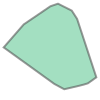

In [43]:
ctmt_area.loc[5, 'geometry']

<AxesSubplot:>

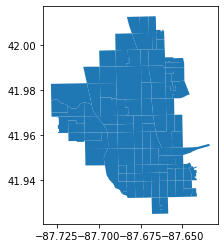

In [44]:
demand.loc[demand['geometry'].centroid.within(ctmt_area.loc[5, 'geometry'])].plot()

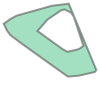

In [45]:
ctmt_area.loc[10, 'geometry']

<AxesSubplot:>

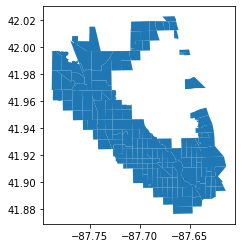

In [46]:
demand.loc[demand['geometry'].centroid.within(ctmt_area.loc[10, 'geometry'])].plot()

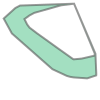

In [47]:
ctmt_area.loc[15, 'geometry']

<AxesSubplot:>

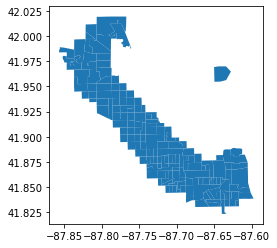

In [48]:
demand.loc[demand['geometry'].centroid.within(ctmt_area.loc[15, 'geometry'])].plot()

In summary, we can define the functions for Enhanced 2SFCA method as shown below. 

In [49]:
def step1_E2SFCA(supply, supply_attr, demand, demand_attr, mobility, thresholds, weights):
    """
    Input: 
    - supply (GeoDataFrame): stores locations and attributes of supply 
    - supply_attr (str): the column of `supply` to be used for the analysis
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - demand_attr (str): the column of `demand` to be used for the analysis
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - thresholds (list): the list of threshold travel times e.g., [5, 10, 15]
    - weights (dict): keys: threshold travel time, values: weigths according to the threshold travel times 
                      e.g., [5: 1, 10: 0.68, 15: 0.22]
    
    Output:
    - supply_ (GeoDataFrame): 
      a copy of supply and it stores supply-to-demand ratio of each supply at `ratio` column
    """
    
    # Your code here (Change the name of the variable according to the inputs)
    supply_ = supply.copy(deep=True)
    supply_['ratio'] = 0

    for i in trange(supply.shape[0]):

        # Create multiple catchment areas from a given location
        ctmt_area = calculate_catchment_area(mobility, supply.loc[i, 'nearest_osm'], thresholds)
    
        # Calculate the population within each catchment area
        ctmt_area_pops = 0
        for c_idx, c_row in ctmt_area.iterrows():
            temp_pop = demand.loc[demand['geometry'].centroid.within(c_row['geometry']), demand_attr].sum()
            ctmt_area_pops += temp_pop*weights[c_idx]

        # Calculate the number of hospital beds in each hospital
        temp_supply = supply.loc[i, supply_attr]

        # Calculate the number of hospital beds available for 100,000 people 
        supply_.at[i, 'ratio'] = temp_supply / ctmt_area_pops * 100000

    
    return supply_


def step2_E2SFCA(result_step1, demand, mobility, thresholds, weights):
    """
    Input: 
    - result_step1 (GeoDataFrame): stores locations and 'ratio' attribute that resulted in step1 
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - thresholds (list): the list of threshold travel times e.g., [5, 10, 15]
    - weights (dict): keys: threshold travel time, values: weigths according to the threshold travel times 
                      e.g., [5: 1, 10: 0.68, 15: 0.22]
    
    Output:
    - demand_ (GeoDataFrame): 
      a copy of demand and it stores the final accessibility measures of each demand location at `ratio` column
    """
    
    # Your code here (Change the name of the variable according to the inputs)
    demand_ = demand.copy(deep=True)
    demand_['access'] = 0

    for j in trange(demand.shape[0]):
        ctmt_area = calculate_catchment_area(mobility, demand.loc[j, 'nearest_osm'], thresholds)

        ctmt_area_ratio = 0
        for c_idx, c_row in ctmt_area.iterrows():
            temp_ratio = result_step1.loc[result_step1['geometry'].centroid.within(c_row['geometry']), 'ratio'].sum()
            ctmt_area_ratio += temp_ratio * weights[c_idx]
            
        demand_.at[j, 'access'] = ctmt_area_ratio

    return demand_

In [50]:
minutes = [5, 10, 15]
weights = {5: 1, 10: 0.68, 15: 0.22}

E_step1 = step1_E2SFCA(supply, 'Total_Bed', demand, 'TotalPop', G, minutes, weights)
E_step2 = step2_E2SFCA(E_step1, demand, G, minutes, weights)

100%|█████████████████████████████████████████| 878/878 [04:52<00:00,  3.00it/s]


<AxesSubplot:>

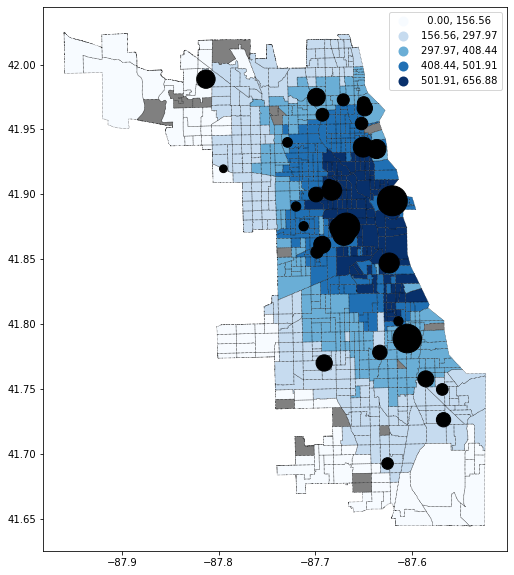

In [51]:
# Plotting accessibility measurement result. 
fig, ax = plt.subplots(figsize=(10,10))

hospitals.plot(markersize='Total_Bed', ax=ax, color='black', zorder=2)
E_step2.plot('access', ax=ax, figsize=(10,10), legend=True, cmap='Blues', scheme='FisherJenks')
E_step2.loc[step2['access'] == 0].plot(ax=ax, color='grey', zorder=1)
E_step2.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)